# Fit Growth Assay data to logistic curve <br>
### importing libraries

In [1]:
import os
import re
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

## The Logistic curve
A logistic curve is a common S-shaped curve that can be usefull for modelling population growth <br>
The equation is:<br>
$$
D(t) = \frac{L}{1 + e^{-k(t-t_0)}}
$$
where: <br>
 - $t_0$ is the sigmoid's midpoint <br> 
 - $L$ is the curve's maximum value <br>
 - $k$ is the logistic growth rate <br>

In [2]:
def logistic_curve_func(L, k, t0, t=np.linspace(-5, 15, 1000)):
    return L / (1. + np.exp(-k * (t - t0)))

### The Parameters
Logistic curve has 3 parameters: $k$, $t_0$ and $L$ <br>
Vary each parameter in order to see their respective influence:

In [ ]:
x = np.linspace(-5, 15, 1000)
fig = plt.figure(figsize=(9, 7))

# vary k
ax = fig.add_subplot(3, 1, 1)
for k in [0, 0.5, 1., 2., 4.]:
    D = logistic_curve_func(L=10000., k=k ,t0=5.)
    _ = plt.plot(x, D, label=f'k={k}')
_ = ax.legend()
_ = ax.set_xlabel('t')
_ = plt.title('k parameter influence - logistic growth rate')

# vary t0 
ax = fig.add_subplot(3, 1, 2)
for t0 in [2 , 4, 6, 8]:
    D = logistic_curve_func(L=10000., k=2 ,t0=t0)
    _ = plt.plot(x, D, label=f't0={t0}')
_ = ax.legend()
_ = ax.set_xlabel('t')
_ = plt.title("t0 parameter influence - sigmoid's midpoint")

# vary L
ax = fig.add_subplot(3, 1, 3)
for L in range(4, 8):
    L *= 2000
    D = logistic_curve_func(L=L, k=2 ,t0=5.)
    _ = plt.plot(x, D, label=f'L={L}')
_ = ax.legend()
_ = ax.set_xlabel('t')
_ = plt.title("L parameter influence - curve's maximum value")

fig.tight_layout(pad=0.3)
plt.show();

## Data
Import data and wrangle it. the result is a dictionary of dataframes, where each key coresspondes to a folder in 'input_directory' <br> 
(plate in the growth assay) and the values are dataframes. <br> 
each dataframe is growth data for one plate in the growth assay. The columns are wells (in 96 well plate), and the rows are timestamps. 

In [3]:
# turn data asc files (raw plate reader files) into dictionary of dataframes

# INPUT: input_directory - string, folder directory, containing subfolders,
#                          each subfolder contains raw asc files for a plate in the growth assay
#                          subfolder names shuld have a number such as 'plate #' or 'Plate #' for the dictionary keys.

# OUTPUT: df_dict - dictionary of dataframes. the keys are the number in the subfolder names in input_directory, 
#                   the values are dataframes where rows=timestemps, columns=wells.
#                   each dataframe in the dictionary correspondes to a plate in the growth assay (subfolder in input_directory).

def wrangle (input_directory):
    df_dict = {}  # init output dictionary with wells as column
    
    for folder in os.listdir(input_directory):  # for each folder (each plate)
        folder_directory = os.path.join(input_directory, folder)
        
        # get sorted list of asc files in 'folder':
        asc_files = [f for f in os.listdir(folder_directory) if f.endswith('.asc')]
        asc_files.remove('Data.asc')
        asc_files = ['Data.asc'] + sorted(asc_files, key=lambda s: int(re.split(r'(\d+)', s)[1]))
        
        # import data from asc files into df (dataframe for current folder)
        wells = pd.read_csv(os.path.join(folder_directory, asc_files[0]), delimiter='\t')['Well positions'][:-2] 
        df = pd.DataFrame(columns=wells)  # init df with column names (wells)
        for cur_file in asc_files:  # for each asc file in 'folder'
            cur_data = ((pd.read_csv(os.path.join(folder_directory, cur_file), delimiter='\t', usecols=['Raw data']))
                        .dropna()
                        .replace(',', '.', regex=True)
                        .transpose()
                        .rename(columns=wells))
            # add cur_data to df
            df = pd.concat([df, cur_data])
        
        # add df to df_dict
        df_dict[int(re.split(r'(\d+)', folder)[1])] = df.reset_index(drop=True).applymap(float)
        
    return df_dict

In [4]:
folder_dir = 'raw data'
df_dict = wrangle(folder_dir)
df_dict[1].head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0.043826,0.044194,0.044890,0.050453,0.043645,0.044557,0.044248,0.044003,0.043497,0.043322,...,0.048617,0.050681,0.048375,0.050107,0.051267,0.051599,0.053226,0.049843,0.049285,0.055510
1,0.044132,0.044299,0.045313,0.050746,0.043610,0.044141,0.043931,0.043203,0.043211,0.043400,...,0.049530,0.049849,0.050547,0.053755,0.051454,0.050661,0.049731,0.050085,0.050494,0.050228
2,0.043826,0.044707,0.045150,0.051101,0.043612,0.044587,0.044492,0.044196,0.044232,0.043919,...,0.049699,0.049254,0.051444,0.055555,0.055139,0.057100,0.049928,0.048851,0.050407,0.052620
3,0.044374,0.044542,0.044496,0.051319,0.043565,0.044393,0.043955,0.043248,0.043339,0.043480,...,0.049868,0.049225,0.052494,0.055068,0.055293,0.054704,0.048614,0.053047,0.054916,0.054108
4,0.043921,0.044574,0.044960,0.051517,0.044089,0.044487,0.044410,0.043484,0.043419,0.044283,...,0.049939,0.049701,0.052150,0.051078,0.055370,0.051425,0.048981,0.047825,0.049965,0.052180


In [5]:
# export wrangled data
export_directory = '.\output folder'
for k in df_dict:
    (df_dict[k]).to_csv(os.path.join(export_directory, 'wrangled ' + str(k) + '.txt'), index=None, sep='\t')

create timestemps for the measurments: <br>
this is th X axis for plotting and for fitting the data <br>
In this experiment, measurments were taken every 30 minutes, for total of 110 measurments (54.5 hours)

In [6]:
# create evenly spaced numbers over a specified interval
t = np.linspace(0, 54.5, 110)  # [hours]

Visualize raw data:

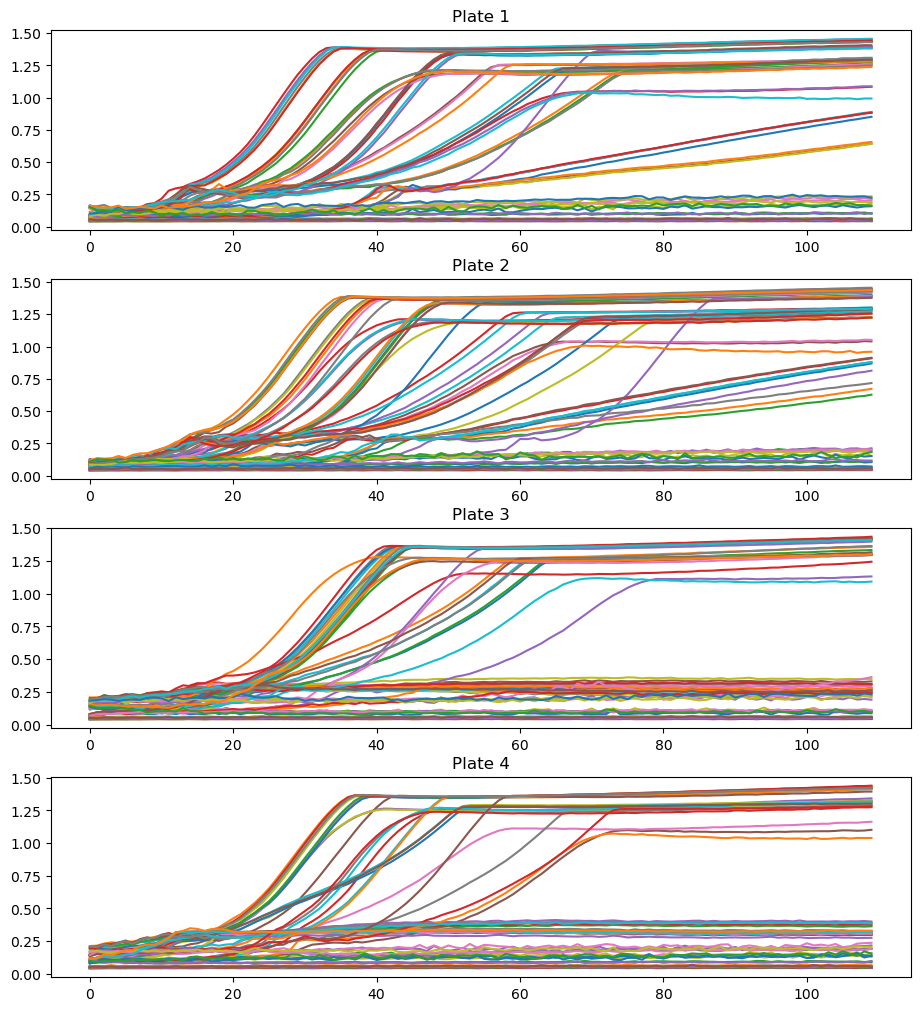

In [7]:
fig = plt.figure(figsize=(9, 10))

for i in range(len(df_dict)):
    ax = fig.add_subplot(4, 1, i+1)
    key = list(df_dict.keys())[i]
    df = df_dict[key]
    df.plot(y=df.columns, ax=ax, title='Plate ' + str(key), legend=False)

fig.tight_layout(pad=0.3)
plt.show();

Average repetitions: <br>
Averageing wells that have the same condition (same media and strain)

In [8]:
# this function average repetitions (wells with the same condition) in the dataframes in df_dict

# INPUT:
#       - GA_conditions_file - file name (string) of xlsx file. 
#                              This file needs to have at least 3 columns: 'Plate', 'Well ID', 'Condition'
#                              Plate = plate number
#                              Well ID = The ID of the wells (row-col: 'A1', 'A2'...)
#                              Condition - The condition in the well (strain / media ...)
#       - df_dict - dictionary where the keys are the plate number (int) and the vlues are the wrangle dataframe
#                   For each dataframe, the columns are wells and the row are timestemps
#       - remove_words_list - list of words (strings) to look for in the 'Condition' column in GA_conditions_file

# OUTPUT:
#       - A dataframe, where every column is a condition, 
#         the values are the mean values of all wells with this condition


def avg_wells_by_condition(GA_conditions_file, df_dict, remove_words_list):
    # load GA_conditions_file into a dataframe (['Plate', 'Well ID', 'Condition'] columns)
    conditions_df = pd.read_excel(GA_conditions_file, usecols=['Plate', 'Well ID', 'Condition'])
    # get conditions list (uniue values), without conditions that have a word from remove_words_list in them
    words = re.compile("|".join(remove_words_list))
    condition_list = [c for c in conditions_df['Condition'].unique() if not words.search(c)]

    # create a dict of edited dataframes from df_dict
    edited_df_dict = {}
    for d in df_dict:
        df = (df_dict[d].transpose()
              .reset_index()
              .rename(columns={'index': 'Well ID'}))
        # use merge to add 'Plate' and 'Condition' columns
        df = df.merge(conditions_df.loc[conditions_df['Plate'] == d, ['Well ID','Condition']], on='Well ID')
        # leave only columns that are in condition_list
        df = df[df['Condition'].isin(condition_list)]
        # add to dict
        edited_df_dict[d] = df
    
    # concat dataframes from edited_df_dict and calculate mean for each Condition
    avg_df = pd.concat(edited_df_dict.values()).groupby(by='Condition').mean().transpose()
    
    return avg_df

In [9]:
GA_conditions_file = 'GA conditions.xlsx'
words = ['Missing', 'blank']

avg_df = avg_wells_by_condition(GA_conditions_file, df_dict, words)
avg_df.head()

Condition,DTT (1mM);BY4741::NAT,DTT (1mM);OE-Yet3,DTT (1mM);dyet3,DTT (2mM);BY4741::NAT,DTT (2mM);OE-Yet3,DTT (2mM);dyet3,Fluconazole (10ug/ml);BY4741::NAT,Fluconazole (10ug/ml);OE-Yet3,Fluconazole (10ug/ml);dyet3,Fluconazole (20ug/ml);BY4741::NAT,...,Terbnarine (10ug/ml);dyet3,Terbnarine (5ug/ml);BY4741::NAT,Terbnarine (5ug/ml);OE-Yet3,Terbnarine (5ug/ml);dyet3,Tunicamycin (2.5 ug/ml);BY4741::NAT,Tunicamycin (2.5 ug/ml);OE-Yet3,Tunicamycin (2.5 ug/ml);dyet3,Tunicamycin (5 ug/ml);BY4741::NAT,Tunicamycin (5 ug/ml);OE-Yet3,Tunicamycin (5 ug/ml);dyet3
0,0.085257,0.085524,0.084867,0.078792,0.082762,0.087691,0.079360,0.080337,0.083121,0.077215,...,0.146663,0.179888,0.169350,0.202688,0.131335,0.134665,0.130698,0.120321,0.121951,0.120997
1,0.090195,0.085925,0.090123,0.092938,0.096492,0.095860,0.087943,0.089194,0.091393,0.090275,...,0.175248,0.185808,0.179803,0.203265,0.129872,0.123458,0.121477,0.127560,0.120803,0.123175
2,0.095833,0.096737,0.098666,0.099296,0.109148,0.111061,0.095362,0.097813,0.103020,0.099052,...,0.173778,0.194943,0.189692,0.219890,0.128751,0.122390,0.121478,0.124719,0.119214,0.124958
3,0.105141,0.102002,0.103679,0.107092,0.112053,0.111382,0.107367,0.108094,0.112489,0.106734,...,0.174943,0.200558,0.193308,0.216187,0.115528,0.114303,0.115366,0.119806,0.118451,0.122303
4,0.109640,0.109846,0.107145,0.115612,0.121755,0.120923,0.109560,0.121222,0.119232,0.110622,...,0.179608,0.208193,0.200760,0.219508,0.122860,0.123337,0.119083,0.114060,0.115482,0.114180


Visualize averaged data:

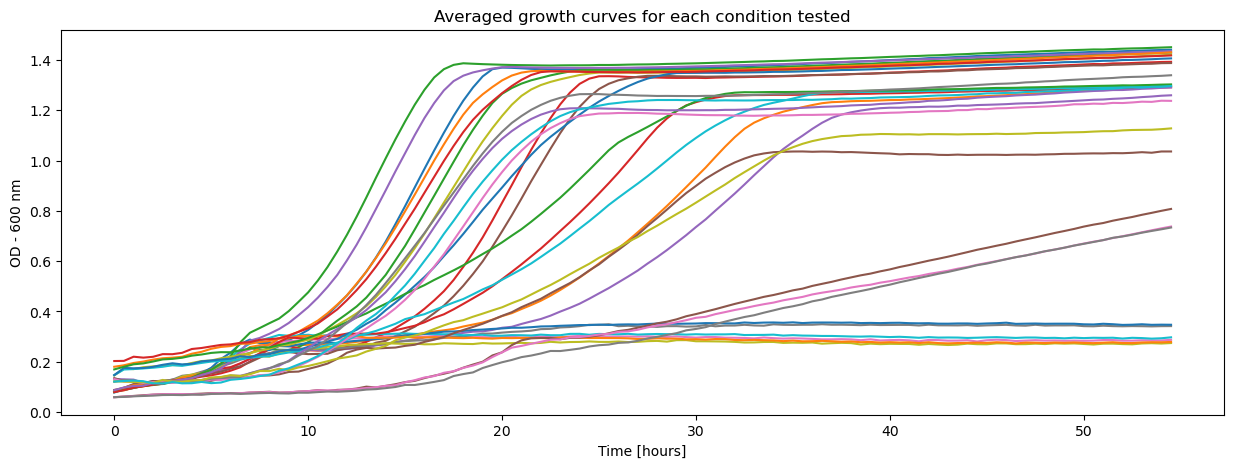

In [10]:
avg_df.set_index(t).plot(legend=False, 
                         figsize=(15,5), 
                         xlabel='Time [hours]', 
                         ylabel='OD - 600 nm', 
                         title='Averaged growth curves for each condition tested');

## Fit data to Logistic curve

In [11]:
def _func(t, *p):  # helper function - logaritmic 
    L, k, t0 = p
    return L / (1. + np.exp(-k * (t - t0)))

# fit data to log curve:
# INPUT:
#      - x - x values for the data (timestemps of the growth assay measurments)
#      - df - data frame, contining y values for each x value
#             In a growth assay, the y values are OD measured at time x_i,
#             each column is a different growth condition
# OUTPUT:
#      - fitted_data - data frame, contining predicted values for each x value in each condition
#      - coeff_data - coefficients ['L', 'k', 't0'] values for each curve fitting

def fit_data_to_log_curve(x, df):
    # init output dataframes
    fitted_data = pd.DataFrame(columns=df.columns)
    coeff_data = pd.DataFrame(columns=df.columns, index=['L', 'k', 't0'])

    for c in df.columns:  # for each column (condition) in df
        y = df[c]
        p0 = [y.max(), 1, np.median(x)]  # estimations for [L, k, t0] - init guess
        # fit column c daya (y values) to function _func:
        coeff, var_matrix = curve_fit(_func, x, y, p0)
        yfit = [_func(xx, *tuple(coeff)) for xx in x]
        # add fitted data to output dataframes
        fitted_data[c] = yfit
        coeff_data[c] = coeff
            
    return fitted_data, coeff_data

In [12]:
log_fit_df, log_fit_coeff = fit_data_to_log_curve(t, avg_df)
log_fit_coeff.head()

Condition,DTT (1mM);BY4741::NAT,DTT (1mM);OE-Yet3,DTT (1mM);dyet3,DTT (2mM);BY4741::NAT,DTT (2mM);OE-Yet3,DTT (2mM);dyet3,Fluconazole (10ug/ml);BY4741::NAT,Fluconazole (10ug/ml);OE-Yet3,Fluconazole (10ug/ml);dyet3,Fluconazole (20ug/ml);BY4741::NAT,...,Terbnarine (10ug/ml);dyet3,Terbnarine (5ug/ml);BY4741::NAT,Terbnarine (5ug/ml);OE-Yet3,Terbnarine (5ug/ml);dyet3,Tunicamycin (2.5 ug/ml);BY4741::NAT,Tunicamycin (2.5 ug/ml);OE-Yet3,Tunicamycin (2.5 ug/ml);dyet3,Tunicamycin (5 ug/ml);BY4741::NAT,Tunicamycin (5 ug/ml);OE-Yet3,Tunicamycin (5 ug/ml);dyet3
L,1.413283,1.368536,1.406568,1.382369,1.380099,1.383535,0.293554,0.345268,0.275112,0.304513,...,1.403157,1.404500,1.338052,1.401678,1.249560,1.078610,1.215081,1.302396,1.179639,1.272021
k,0.316155,0.132861,0.295135,0.268944,0.119337,0.260368,0.411426,0.175980,0.318857,0.452970,...,0.208682,0.269242,0.151053,0.250548,0.291083,0.159231,0.290427,0.296036,0.136017,0.286456
t0,13.438729,24.847525,14.625788,17.931188,27.715848,18.793163,3.440020,5.262827,3.077277,3.559245,...,17.208433,13.349528,18.349276,13.654888,14.860455,22.259800,16.059099,14.957948,23.395257,15.873258


Visualize fitted data:

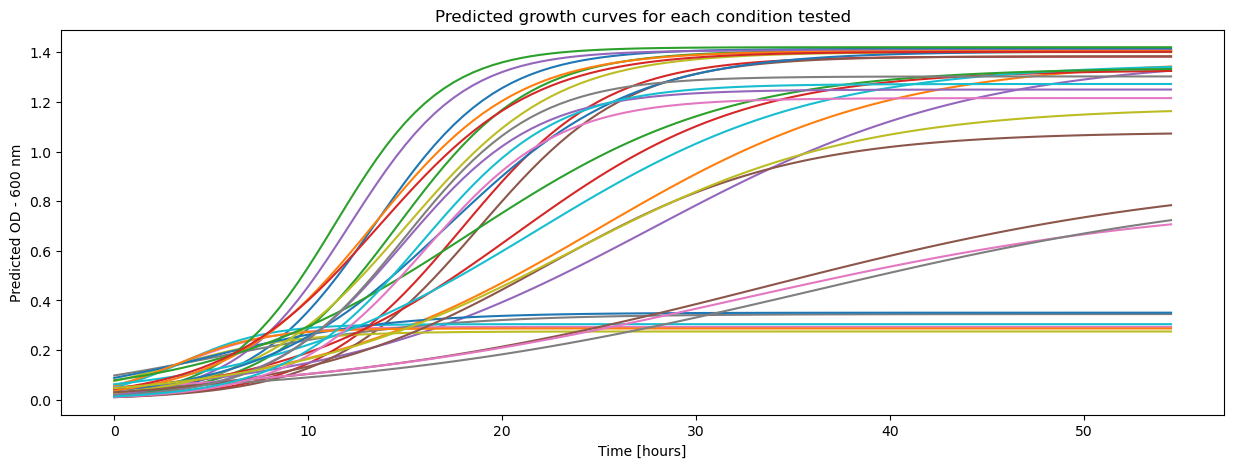

In [13]:
log_fit_df.set_index(t).plot(legend=False, 
                             figsize=(15,5), 
                             xlabel='Time [hours]', 
                             ylabel='Predicted OD - 600 nm', 
                             title='Predicted growth curves for each condition tested');

Plot coefficients: <br>
* sort by k - growth rate

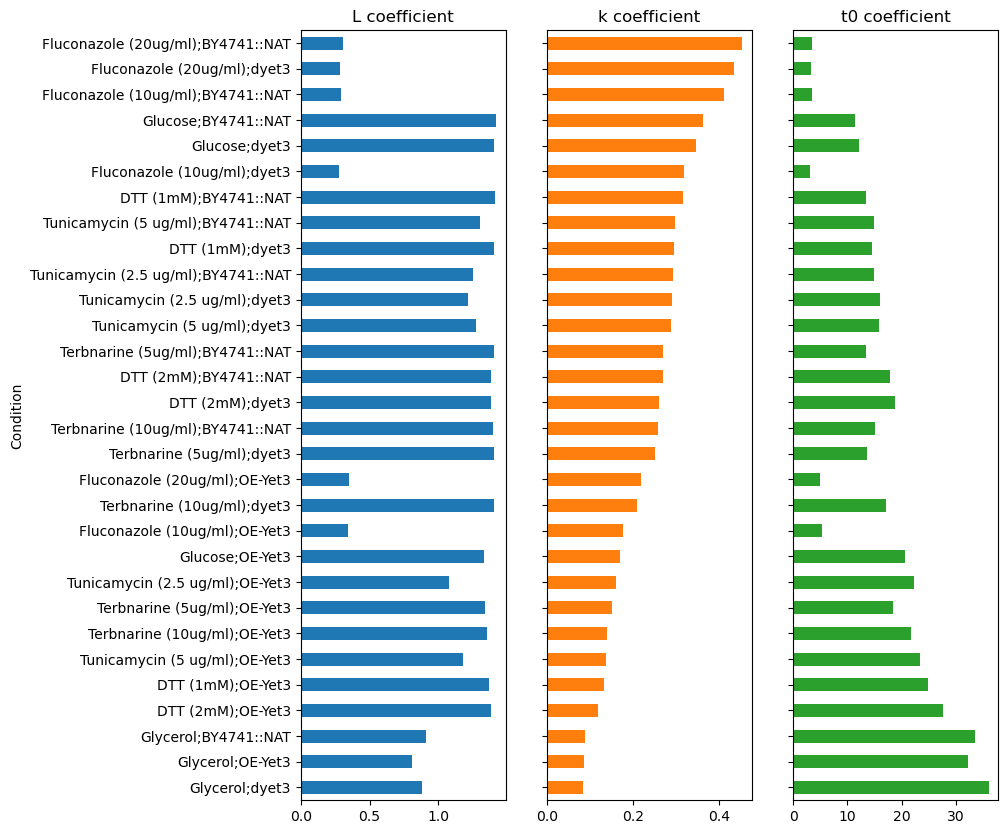

In [17]:
(log_fit_coeff.transpose().sort_values(by='k')
 .plot(kind='barh', 
       subplots=True, layout=(1, 3), 
       sharey=True, sharex=False,
       legend=False, 
       title=['L coefficient', 'k coefficient', 't0 coefficient'],
       fontsize=10,
       figsize=(9, 10)));

## Goodness-of-Fit 
### R Squared (the coefficient of determination) 
A data set has n values marked $y_1,...,y_n$, each associated with a fitted (or modeled, or predicted) value $\hat{y}_1,...,\hat{y}_n$. <br>
Define the residuals as $e_i = y_i−\hat{y}_i$ (forming a vector e).<br>
The mean of the observed data:<br>
$$ y_{avg} = \frac{1}{n}\sum\limits_{i=1}^{n}y_i $$<br>
The sum of squares of residuals:<br>
$$ SS_{res} = \sum\limits_{i}(y_i-\hat{y}_i)^2 = \sum\limits_{i}e_{i}^2 $$ <br>
The total sum of squares (proportional to the variance of the data): <br>
$$ SS_{total} = \sum\limits_{i}(y_i-y_{avg})^2 $$ <br>
The most general definition of the coefficient of determination is: <br>
$$ R^2 = 1 - \frac{SS_{res}}{SS_{total}} $$ <br>
In the best case, the modeled values exactly match the observed values, which results in: $SS_{res} = 0$ and $R^2 = 1$.<br>
A baseline model, which predicts $\hat{y}=y_{avg}$ will have $R^2 = 0$. <br>
Models that are worse than this baseline will have $R^2 < 0$

In [18]:
# helper function - 
# this function computes the r^2 score of 2 serieses and return a series with 1 value (the r^2 score)
def r2_score_func(y, y_pred):
    return pd.Series(r2_score(y, y_pred))

# This function calculates the r^2 score for a dictionary of dataframes

# INPUT: 
#      - y_df - data frame, contining OD measurments for timestemp x 
#               each column is a different growth condition
#      - y_pred_df - data frame, contining predicted/fitted OD for timestemp x 
#                    each column is a different growth condition

# NOTE: dataframes columns have to match

# OUTPUT: df with R Squared for each corresponding columns in the input dataframes

def R_Squared_for_df(y_df, y_pred_df):
    # assert that both dataframes have the same columns
    assert all(y_df.columns) == all(y_pred_df.columns), f'Dataframes columns not matching'
    
    # calculate r2 score for each 2 corresponding columns
    r2_score_df = y_df.combine(y_pred_df, r2_score_func).dropna()

    return r2_score_df


In [19]:
r2_score = R_Squared_for_df(avg_df, log_fit_df)

r2_score

Condition,DTT (1mM);BY4741::NAT,DTT (1mM);OE-Yet3,DTT (1mM);dyet3,DTT (2mM);BY4741::NAT,DTT (2mM);OE-Yet3,DTT (2mM);dyet3,Fluconazole (10ug/ml);BY4741::NAT,Fluconazole (10ug/ml);OE-Yet3,Fluconazole (10ug/ml);dyet3,Fluconazole (20ug/ml);BY4741::NAT,...,Terbnarine (10ug/ml);dyet3,Terbnarine (5ug/ml);BY4741::NAT,Terbnarine (5ug/ml);OE-Yet3,Terbnarine (5ug/ml);dyet3,Tunicamycin (2.5 ug/ml);BY4741::NAT,Tunicamycin (2.5 ug/ml);OE-Yet3,Tunicamycin (2.5 ug/ml);dyet3,Tunicamycin (5 ug/ml);BY4741::NAT,Tunicamycin (5 ug/ml);OE-Yet3,Tunicamycin (5 ug/ml);dyet3
0,0.988021,0.973966,0.990389,0.980416,0.972769,0.980662,0.968898,0.987054,0.98805,0.957898,...,0.987698,0.980282,0.985639,0.978602,0.989798,0.978701,0.98916,0.99244,0.990199,0.993359
